# Train Baseline

smol explanation...

## Setup

### Environment

In [1]:
# If this is a notebook which is executed in colab [in_colab=True]:
#  1. Mount google drive and use the repository in there [mount_drive=True] (the repository must be in your google drive root folder).
#  2. Clone repository to remote machine [mount_drive=False].
in_colab = False
mount_drive = True

try:
    # Check if running in colab.
    in_colab = 'google.colab' in str(get_ipython())
except:
    pass

if in_colab:
    if mount_drive:
        # Mount google drive and navigate to it.
        from google.colab import drive
        drive.mount('/content/drive')
        %cd drive/MyDrive
    else:
        # Pull repository.
        !git clone https://github.com/HenningBuhl/low-resource-machine-translation

    # Workaround for problem with undefined symbols (https://github.com/scverse/scvi-tools/issues/1464).
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

    # Navigate to the repository and install requirements.
    %cd low-resource-machine-translation
    !pip install -r requirements.txt

    # Navigate to notebook location.
    %cd experiments

In [2]:
# Add src module directory to system path for subsecuent imports.
import sys
sys.path.insert(0, '../src')

In [3]:
from util import is_notebook

# Settings and module reloading (only in Jupyter Notebooks).
if is_notebook():
    # Module reloading.
    %load_ext autoreload
    %autoreload 2

    # Plot settings.
    %matplotlib inline

### Imports

In [4]:
# From packages.
import pytorch_lightning as pl

# From repository.
from arguments import *
from benchmark import *
from calc import *
from constants import *
from data import *
from layers import *
from metric_logging import *
from plotting import *
from path_management import *
from tokenizer import *
from transformer import *
from util import *

### Arguments

In [5]:
# Define arguments with argparse.
import argparse
from distutils.util import strtobool
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# Experiment.
parser.add_argument('--dev-run', default=False, type=strtobool, help='Executes a fast dev run instead of fully training.')
parser.add_argument('--fresh-run', default=False, type=strtobool, help='Ignores all cashed data on disk, reruns generation and overwrites everything.')
parser.add_argument('--seed', default=0, type=int, help='The random seed of the program.')
parser.add_argument('--src-lang', default='de', type=str, help='The source language.')
parser.add_argument('--tgt-lang', default='nl', type=str, help='The target language.')
parser.add_argument('--eval-before-train', default=False, type=strtobool, help='Evaluate the model on the validation data before training.')

# Metrics.
parser.add_argument('--track-bleu', default=True, type=strtobool, help='Whether to track the SacreBLEU score metric.')
parser.add_argument('--track-ter', default=False, type=strtobool, help='Whether to track the translation edit rate metric.')
parser.add_argument('--track-tp', default=False, type=strtobool, help='Whether to track the translation perplexity metric.')
parser.add_argument('--track-chrf', default=False, type=strtobool, help='Whether to track the CHRF score metric.')

# Data.
parser.add_argument('--shuffle-before-split', default=False, type=strtobool, help='Whether to shuffle the data before creating the train, validation and test sets.')
parser.add_argument('--num-val-examples', default=3000, type=int, help='The number of validation examples.') 
parser.add_argument('--num-test-examples', default=3000, type=int, help='The number of test examples.')

# Tokenization.
parser.add_argument('--src-vocab-size', default=16000, type=int, help='The vocabulary size of the source language tokenizer.')
parser.add_argument('--src-char-coverage', default=1.0, type=float, help='The character coverage (percentage) of the source language tokenizer.')
parser.add_argument('--tgt-vocab-size', default=16000, type=int, help='The vocabulary size of the target language tokenizer.')
parser.add_argument('--tgt-char-coverage', default=1.0, type=float, help='The character coverage (percentage) of the target language tokenizer.')

# Architecture.
parser.add_argument('--num-layers', default=6, type=int, help='The number of encoder and decoder layers.')
parser.add_argument('--d-model', default=512, type=int, help='The embedding size.')
parser.add_argument('--dropout-rate', default=0.1, type=float, help='The dropout rate.')
parser.add_argument('--num-heads', default=8, type=int, help='The number of attention heads.')
parser.add_argument('--d-ff', default=2048, type=int, help='The feed forward dimension.')
parser.add_argument('--max-len', default=128, type=int, help='The maximum sequence length.')

# Optimizer.
parser.add_argument('--learning-rate', default=1e-4, type=float, help='The learning rate.')
parser.add_argument('--weight-decay', default=0, type=float, help='The weight decay.')
parser.add_argument('--beta-1', default=0.9, type=float, help='Beta_1 parameter of Adam.')
parser.add_argument('--beta-2', default=0.98, type=float, help='Beta_2 parameter of Adam.')

# Scheduler.
parser.add_argument('--enable-scheduling', default=False, type=strtobool, help='Whether to enable scheduling.')
parser.add_argument('--warm-up-steps', default=4000, type=int, help='The number of warm up steps.')

# Training.
parser.add_argument('--batch-size', default=80, type=int, help='The batch size.')
parser.add_argument('--label-smoothing', default=0, type=float, help='The amount of smoothing when calculating the loss.')
parser.add_argument('--max-epochs', default=10, type=int, help='The maximum number of training epochs.')
parser.add_argument('--max-examples', default=-1, type=int, help='The maximum number of training examples.')
parser.add_argument('--shuffle-train-data', default=True, type=strtobool, help='Whether to shuffle the training data during training.')
parser.add_argument('--gpus', default=1, type=int, help='The number of GPUs.')
parser.add_argument('--num-workers', default=4, type=int, help='The number of pytorch workers.')
parser.add_argument('--ckpt-path', default=None, type=str, help='The model checkpoint form which to resume training.')

# Early Stopping + Model Checkpoint.
parser.add_argument('--enable-early-stopping', default=False, type=strtobool, help='Whether to enable early stopping.')
parser.add_argument('--enable-checkpointing', default=False, type=strtobool, help='Whether to enable checkpointing. The best and the last version of the model are saved.')
parser.add_argument('--monitor', default='val_loss', type=str, help='The metric to monitor.')
parser.add_argument('--min-delta', default=0, type=float, help='The minimum change the metric must achieve.')
parser.add_argument('--patience', default=3, type=int, help='Number of epochs that the monitored metric has time to improve.')
parser.add_argument('--mode', default='min', type=str, choices=['min', 'max'], help='How the monitored metric should improve.')

# Parse args.
if is_notebook():
    sys.argv = ['-f']  # Used to make argparse work in jupyter notebooks (all args must be optional).
    args, _ = parser.parse_known_args()  # -f can lead to unknown argument.
else:
    args = parser.parse_args()

# Print args.
print('Arguments:')
print(args)

Arguments:
Namespace(dev_run=False, fresh_run=False, seed=0, src_lang='de', tgt_lang='nl', eval_before_train=False, track_bleu=True, track_ter=False, track_tp=False, track_chrf=False, shuffle_before_split=False, num_val_examples=3000, num_test_examples=3000, src_vocab_size=16000, src_char_coverage=1.0, tgt_vocab_size=16000, tgt_char_coverage=1.0, num_layers=6, d_model=512, dropout_rate=0.1, num_heads=8, d_ff=2048, max_len=128, learning_rate=0.0001, weight_decay=0, beta_1=0.9, beta_2=0.98, enable_scheduling=False, warm_up_steps=4000, batch_size=80, label_smoothing=0, max_epochs=10, max_examples=-1, shuffle_train_data=True, gpus=1, num_workers=4, ckpt_path=None, enable_early_stopping=False, enable_checkpointing=False, monitor='val_loss', min_delta=0, patience=3, mode='min')


In [6]:
# Auto-infer args.
auto_infer_args(args)

In [34]:
# Adjust arguments for test purposes.
if is_notebook() and True:  # Quickly turn on and off with 'and True/False'.
    #args.dev_run = True
    #args.fresh_run = True
    args.max_epochs = 10 # 2
    args.batch_size = 1
    args.max_examples = 2
    args.num_val_examples = 1
    args.num_test_examples = 1

    #args.enable_checkpointing = True
    #args.enable_early_stopping = True

    #args.eval_before_train = False

    #args.label_smoothing = 0.1

    #args.track_ter = True
    #args.track_tp = True
    #args.track_chrf = True
    print('Adjusted args in notebook')

Adjusted args in notebook


In [35]:
# Sanity check args.
sanity_check_args(args)

### Seed

In [36]:
# Set seed.
from pytorch_lightning import seed_everything
seed_everything(args.seed, workers=True)

Global seed set to 0


0

### Paths

In [37]:
# Create directories and create file names.
pm = ExperimentPathManager(f'baseline-{args.src_lang}-{args.tgt_lang}', 'baseline')
pm.init()

Dir "./data" already exists.
Dir "./models" already exists.
Dir "./runs" already exists.
Dir "./tokenizers" already exists.
Dir "./runs\baseline-de-nl-2022.10.01-13.22.48" does not exist, creating it.
Dir "./runs\baseline-de-nl-2022.10.01-13.22.48\baseline" does not exist, creating it.
Dir "./runs\baseline-de-nl-2022.10.01-13.22.48\baseline\checkpoints" does not exist, creating it.
Dir "./runs\baseline-de-nl-2022.10.01-13.22.48\baseline\metrics" does not exist, creating it.


In [38]:
# Save arguments.
save_dict(pm.args_file, args.__dict__)

## Data Preprocessing

In [39]:
# Create PreProcessor.
pp = PreProcessor(args.src_lang, args.tgt_lang)

### Splitting

In [40]:
# Split data into (train, val, test) sets.
pp.split_data(args.shuffle_before_split, args.num_val_examples, args.num_test_examples, args.fresh_run)

Data is already split.


### Tokenizers

In [41]:
# Load tokenizers.
src_tokenizer = TokenizerBuilder(args.src_lang, args.tgt_lang).build(
    args.src_vocab_size, args.src_char_coverage, fresh_run=args.fresh_run)
tgt_tokenizer = TokenizerBuilder(args.tgt_lang, args.src_lang).build(
    args.tgt_vocab_size, args.tgt_char_coverage, fresh_run=args.fresh_run)

Loading tokenizer from disk.
Loading tokenizer from disk.


### Preparation

In [42]:
# Load dataloaders.
train_dataloader, val_dataloader, test_dataloader = pp.pre_process(src_tokenizer, tgt_tokenizer, args.batch_size, args.shuffle_train_data, args.max_examples, args.max_len, fresh_run=args.fresh_run)

Loading tokenized data from disk.
Limiting training data to 10000


## Experiment

### Model

In [44]:
# Create model.
model = Transformer(
    src_tokenizer,
    tgt_tokenizer,
    args.learning_rate,
    args.weight_decay,
    args.beta_1,
    args.beta_2,
    args.enable_scheduling,
    args.warm_up_steps,
    args.num_layers,
    args.d_model,
    args.dropout_rate,
    args.num_heads,
    args.d_ff,
    args.max_len,
    args.label_smoothing,
    args.track_bleu,
    args.track_ter,
    args.track_tp,
    args.track_chrf,
)

In [19]:
# Save untrained model.
model.save(pm.baseline.untrained_model_file)

### Training

In [45]:
# Create callbacks.
callbacks = []

if args.enable_checkpointing:
    model_checkpoint = pl.callbacks.ModelCheckpoint(
        monitor=args.monitor,
        dirpath=pm.baseline.checkpoint_dir,
        filename='{epoch}-{val_loss:.2f}',
        save_top_k=1,
        save_last=True,
        every_n_epochs=1,
        verbose=True,
    )
    callbacks.append(model_checkpoint)

if args.enable_early_stopping:
    early_stopping_callback = pl.callbacks.EarlyStopping(
        monitor=args.monitor,
        min_delta=args.min_delta,
        patience=args.patience,
        mode=args.mode,
        verbose=True,
    )
    callbacks.append(early_stopping_callback)

if args.enable_scheduling:
    lr_monitor = pl.callbacks.LearningRateMonitor(
        logging_interval='step',
        log_momentum=True
    )
    callbacks.append(lr_monitor)

In [46]:
# Create metric logger.
metric_logger = MetricLogger()

In [47]:
# Create trainer.
trainer = pl.Trainer(
    deterministic=True,
    fast_dev_run=args.dev_run,
    max_epochs=args.max_epochs,
    logger=metric_logger,
    log_every_n_steps=1,
    enable_checkpointing=args.enable_checkpointing,
    default_root_dir=pm.baseline.checkpoint_dir,
    callbacks=callbacks,
    gpus=args.gpus if str(device) == 'cuda' else 0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
# Evaluate before training.
if args.eval_before_train:
    trainer.validate(model, dataloaders=val_dataloader)

In [49]:
# Training.
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            ckpt_path=args.ckpt_path)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
# Save model.
if args.enable_checkpointing:
    model.load_from_checkpoint(model_checkpoint.best_model_path)

model.save(pm.baseline.model_file)

### Testing

In [31]:
# Testing.
test_metrics = trainer.test(model, dataloaders=test_dataloader)

C:\Users\Valkyrias\anaconda3\envs\mt\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_bleu_epoch                0.0
     test_loss_epoch         46.61362838745117
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Exporting Results

In [32]:
# Save recorded metrics.
metric_logger.manual_save(pm.baseline.metrics_dir, pm.baseline.metrics_file)

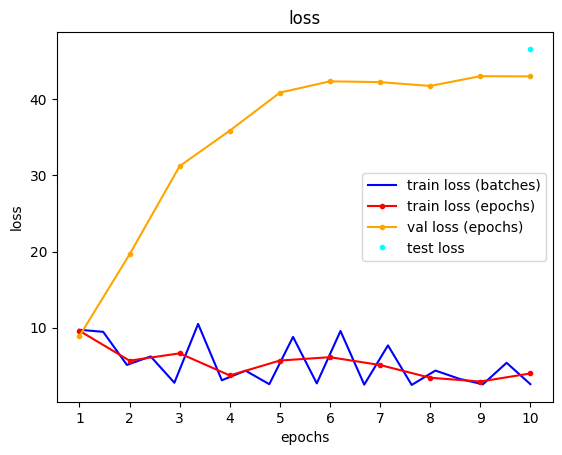

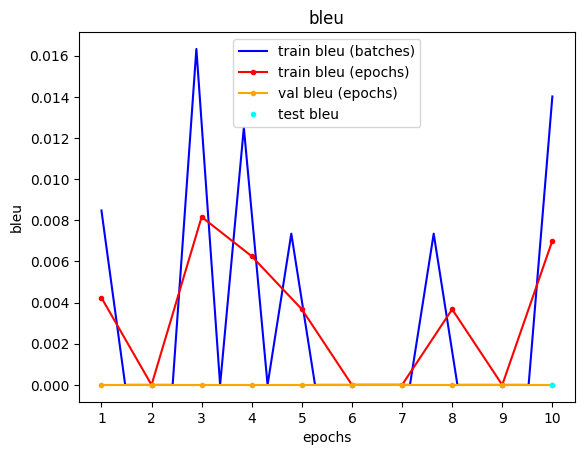

In [33]:
# Save metric plots.
for metric in model.tracked_metrics:
    plot_metric(metric_logger.metrics, metric,
                save_path=pm.baseline.metrics_svg_template.format(metric))